# Загрузка данных и предварительная информация

In [1]:
import pandas as pd
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Информация, представленная на kaggle.
- Представлены только числовые переменные.
- V1, V2, ..., V28 - результат преобразования PCA. Исходные характеристики не представлены из-за проблем с кофиденциальностью.
- "Time" - кол-во секунд между каждой транзакцией и первой транзакцией в датасэте.
- "Amount" - сумма транзакции.
- "Class" - переменная, принимающая значение 1 в случае мошенничества (иначе принимает значение 0).

# Разведочный анализ данных и обработка

In [2]:
data.isnull().any().any()

False

Пропусков в данных нет.

In [3]:
data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

Как видим, кол-ва объектов разных классов существенно различаются (классы не сбалансированы).<br>Первая мысль: часто к дисбалансу приводит наличие дубликатов. 

In [4]:
data.duplicated().any()

True

In [5]:
data = data.drop_duplicates()
data.duplicated().any()

False

Удалили дубликаты.

In [6]:
data['Class'].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

Как можно видеть, классы все равно не сбалансированы.<br>Прежде чем идти дальше, посмотрим за зависимости в данных на подвыборке из данных, в которой нет несбалансированности классов (т.к. наличие несбалансированности может сильно искажать картину). Мы произведем недосэмплирование.

In [7]:
from imblearn.under_sampling import RandomUnderSampler
X = data.drop('Class', axis=1)
y = data['Class']

In [8]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)

<Axes: >

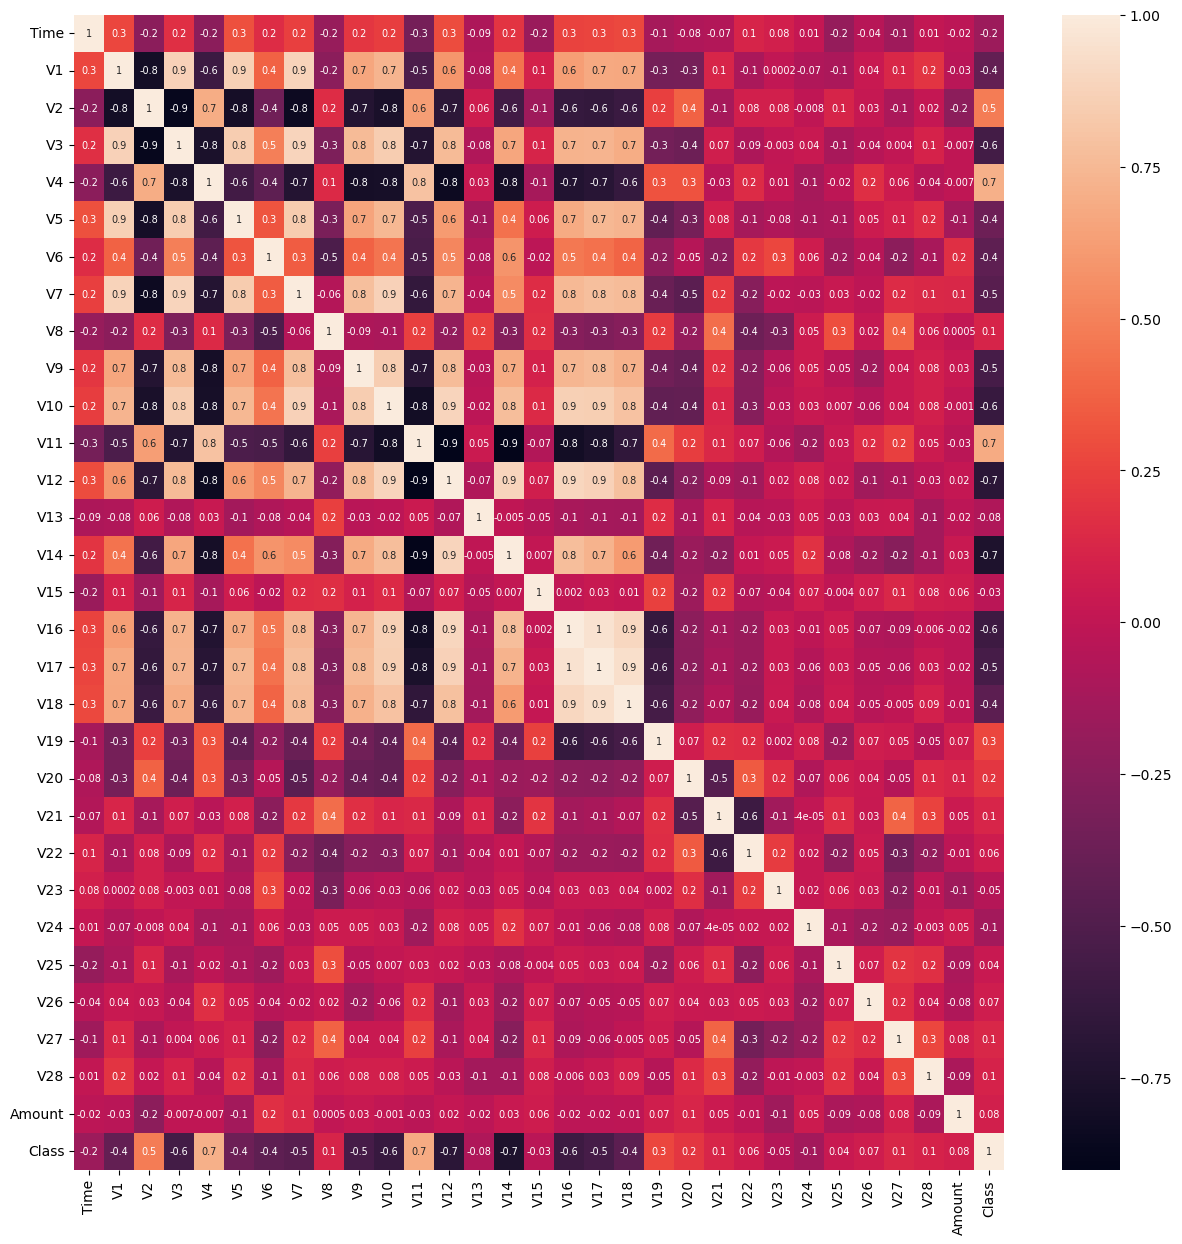

In [9]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 15))
sns.heatmap(pd.concat([X_rus, y_rus], axis=1).corr(), annot=True,
            annot_kws={"size": 7}, fmt='.1g')

In [10]:
indexes, features = [], []
class_corr = pd.concat([X_rus, y_rus], axis=1).corr()['Class']
for index, column in enumerate(class_corr.keys()):
    if class_corr[column] > 0.20 and column != 'Class':
        indicator = True
        for feature in features:
            if pd.concat([X_rus, y_rus], axis=1).corr()[column][feature] > 0.80:
                indicator = False
                break
        if indicator:
            indexes.append(index)
            features.append(column)
print(indexes)
print(features)

[2, 4, 11, 19, 20]
['V2', 'V4', 'V11', 'V19', 'V20']


Мы отобрали признаки, которые имеют наибольшее влияние на целевую переменную (в целом, границы можно менять, но пока остановимся на этом).

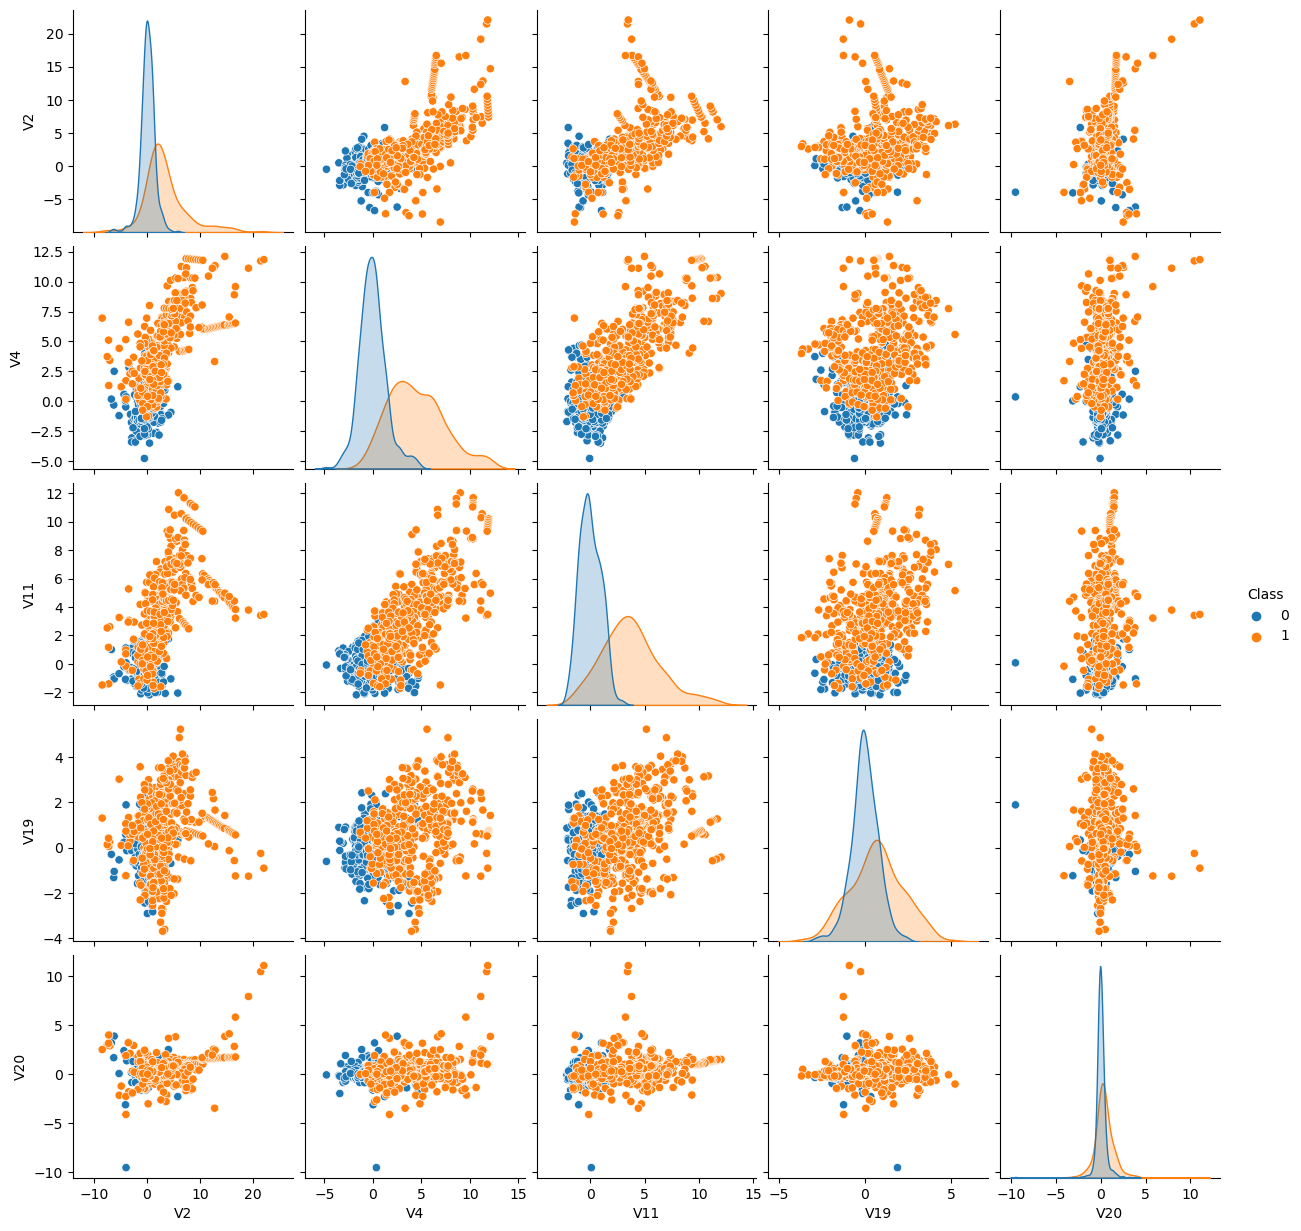

In [11]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(pd.concat([X_rus, y_rus], axis=1).iloc[
    :,
    indexes+[30]
], hue='Class')

Посмотрим на основные статистики признаков.

In [12]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


В целом, можно сделать такие выводы.
- На пересечениях многих признаков можно "выделить" группы мошеннических действий (что видно по pairplot).
- График heatmap визуализирует описанную логику отбора влиятельных признаков.
- Time имеет сильно выделяющиеся основные статистики. Кроме того, почти не коррелирует с целевой переменной. Логично: это время с первой транзакции в датасэте, оно и не должно оказывать влияние на нашу целевую переменную. Это и не подтвердилось логикой отбора признаков.

In [13]:
X = X[features]
X_rus = X_rus[features]

# Разделение данных на train/test

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42)
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(
    X_rus, y_rus, test_size=0.20, random_state=42
)

In [15]:
X_train.describe()

,V2,V4,V11,V19,V20
count,226980.000000,226980.000000,226980.000000,226980.000000,226980.000000
mean,-0.002854,-0.002222,-0.000001,-0.000279,0.000378
std,1.649149,1.415649,1.019544,0.813425,0.768462
min,-72.715728,-5.683171,-4.797473,-7.213527,-54.497720
25%,-0.599484,-0.849764,-0.761411,-0.456285,-0.211497
50%,0.064758,-0.022311,-0.032596,0.003468,-0.062343
75%,0.800914,0.741202,0.739310,0.458725,0.133300
max,22.057729,16.875344,12.018913,5.591971,39.420904


In [16]:
y_train.describe()

count    226980.000000
mean          0.001687
std           0.041043
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Class, dtype: float64

In [17]:
X_test.describe()

,V2,V4,V11,V19,V20
count,56746.000000,56746.000000,56746.000000,56746.000000,56746.000000
mean,-0.009258,-0.005944,0.001014,-0.000204,-0.000577
std,1.636887,1.408316,1.015427,0.813199,0.776050
min,-42.172688,-5.600607,-4.682931,-4.575941,-21.387122
25%,-0.603852,-0.851132,-0.762606,-0.456308,-0.211339
50%,0.059928,-0.021964,-0.030913,0.002930,-0.062393
75%,0.796954,0.733680,0.740715,0.457759,0.133028
max,16.713389,13.143668,11.619723,4.891062,26.237391


In [18]:
y_test.describe()

count    56746.000000
mean         0.001586
std          0.039794
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Class, dtype: float64

In [19]:
X_rus_test.describe()

,V2,V4,V11,V19,V20
count,190.000000,190.000000,190.000000,190.000000,190.000000
mean,1.742223,2.625466,2.119778,0.319075,0.223736
std,3.396131,3.265382,2.885746,1.380492,0.918329
min,-7.196980,-2.831898,-2.164902,-2.901328,-3.042626
25%,-0.052808,0.153269,-0.202342,-0.503866,-0.168885
50%,1.024697,1.717639,1.171539,0.150742,0.093156
75%,2.774973,5.141343,4.032859,1.079581,0.530718
max,15.536133,11.927512,11.669205,5.228342,4.100019


In [20]:
y_rus_train.describe()

count    756.000000
mean       0.490741
std        0.500245
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Class, dtype: float64

In [21]:
X_rus_test.describe()

,V2,V4,V11,V19,V20
count,190.000000,190.000000,190.000000,190.000000,190.000000
mean,1.742223,2.625466,2.119778,0.319075,0.223736
std,3.396131,3.265382,2.885746,1.380492,0.918329
min,-7.196980,-2.831898,-2.164902,-2.901328,-3.042626
25%,-0.052808,0.153269,-0.202342,-0.503866,-0.168885
50%,1.024697,1.717639,1.171539,0.150742,0.093156
75%,2.774973,5.141343,4.032859,1.079581,0.530718
max,15.536133,11.927512,11.669205,5.228342,4.100019


In [22]:
y_rus_test.describe()

count    190.000000
mean       0.536842
std        0.499958
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Class, dtype: float64

Статистики подвыборок без применения перебалансировки отличаются несильно от статистик генеральной выборки. Однако при перебалансировке ситуация иная. Значения mean и std увеличиваются, в то время как значение min и max изменяются несильно.

Перед тем как применять непосредственно модели, нужно нормализовать данные.

In [23]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

# Обучить модели классификации

Сначала немного об используемых метриках.
Метрика precision есть доля объектов, распознанных моделью в качестве положительных и действительно являющихся положительными.
Метрика recall - доля найденных алгоритмом объектов положительного класса из всех объектов положительного класса.
Метрика f1 - среднее гармоническое описанных метрик.

Сначала применим логистическую регрессию. Здесь нам не нужно делать перебалансировку, т.к. в качестве функции ошибки (функционала качества) выступает LogLoss. При применении перебалансировки решение будет неоткалиброванным.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42)

In [25]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56656
           1       0.02      0.86      0.05        90

    accuracy                           0.95     56746
   macro avg       0.51      0.90      0.51     56746
weighted avg       1.00      0.95      0.97     56746



Как можно видеть, логистическая регрессия дала плохой результат. Попробуем использовать нелинейный классификатор lightgbm. Сначала тоже обучим на несбалансированной выборке, затем поэкспериментируем с балансировкой.

In [27]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(verbose=-1)
lgbm.fit(X_train, y_train)
y_predict = lgbm.predict(X_test)

In [28]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56656
           1       0.13      0.42      0.20        90

    accuracy                           0.99     56746
   macro avg       0.56      0.71      0.60     56746
weighted avg       1.00      0.99      1.00     56746



Результат все еще не очень. Мы применили lightgbm на несбалансированных классах.

In [29]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_resample(X, y)
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(
    X_rus, y_rus, test_size=0.20, random_state=42)

In [30]:
lgbm = LGBMClassifier(verbose=-1)
lgbm.fit(X_rus_train, y_rus_train)
y_rus_predict = lgbm.predict(X_rus_test)

In [31]:
print(classification_report(y_rus_test, y_rus_predict))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        88
           1       0.93      0.91      0.92       102

    accuracy                           0.92       190
   macro avg       0.92      0.92      0.92       190
weighted avg       0.92      0.92      0.92       190



Как видим, самый хороший результат получается с применением сэмплирования.